# Workflow to develop a classifier to distinguish between True vs False binding
## Problem
- Can we use AFminD to improve the prediction accuracy of binding sites?
- Are there additional metrics that can be used with AFminD for classification?
## Approach
1. Obtain AF predictions of full-length IDP + domain receptor (uidr) and full-length receptor + domain IDP (urdi) -> run AFminD to obtain potential binding sites and submit these predictions to AF

2. Obtain metrics (confidence scores, PyRosetta scores, electrostatics)
- Some questions: 
    - What should be set as target vs binder? (currently using IDP as target_chain for uidr, and receptor as target_chain for urdi) (only affects `binder_dSASA` and `binder_dG`)

3. Develop the classifier

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

## Load all datasets

In [4]:
urdi = pd.read_csv("uniprot_receptor_domain_idp_all_predictions.tsv", sep="\t")
uidr = pd.read_csv("uniprot_idp_domain_receptor_all_predictions.tsv", sep='\t')

C:\Users\Admin\AppData\Local\Temp\ipykernel_13272\968385672.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  urdi = pd.read_csv("uniprot_receptor_domain_idp_all_predictions.tsv", sep="\t")


In [11]:
urdi[(urdi["interacting_complex"] == True) & (urdi["section"] != "FD")][["job_name", "best_overlap", "true_overlap", "section"]].sort_values(by="best_overlap", ascending=False).to_csv("filter.csv", index=False)

In [29]:
urdi["mean_plddt_A"] = urdi["plddt_A"].apply(lambda x: np.mean(literal_eval(x)))
urdi["mean_plddt_B"] = urdi["plddt_B"].apply(lambda x: np.mean(literal_eval(x)))

In [41]:
confidence_scores = ["global_plddt", "mean_plddt_A", "mean_plddt_B",
                     'ptm', 'iptm', 'combined_score', 'ipSAE_max', 
                     'pDockQ_max', 'pDockQ2_max', 'LIS_max', 
                     'ipsae_A_B', 'pdockq2_A_B', 'lis_A_B', 
                     'ipsae_B_A', 'pdockq2_B_A', 'lis_B_A']
pyrosetta_scores = ['interface_dG', 'interface_SASA', 'interface_dG_SASA_ratio', 
                    'shape_complementarity', 'num_interface_residues', 'buried_unsatisfied_hbonds', 
                    'packstat', 'binder_dG', 'binder_SASA']
electrostatics = ['idp_core_charged', 'receptor_core_charged', 'idp_interface_charged', 
                  'receptor_interface_charged', 'idp_rim_charged', 'receptor_rim_charged', 
                  'idp_surface_charged', 'receptor_surface_charged', 'idp_core_hydropathy', 
                  'receptor_core_hydropathy', 'idp_interface_hydropathy', 'receptor_interface_hydropathy', 
                  'idp_rim_hydropathy', 'receptor_rim_hydropathy', 'idp_surface_hydropathy', 
                  'receptor_surface_hydropathy', 'idp_core_hydrophobic', 'receptor_core_hydrophobic', 
                  'idp_interface_hydrophobic', 'receptor_interface_hydrophobic', 'idp_rim_hydrophobic', 
                  'receptor_rim_hydrophobic', 'idp_surface_hydrophobic', 'receptor_surface_hydrophobic', 
                  'idp_core_polar', 'receptor_core_polar', 'idp_interface_polar', 
                  'receptor_interface_polar', 'idp_rim_polar', 'receptor_rim_polar', 
                  'idp_surface_polar', 'receptor_surface_polar', 'idp_core_small', 
                  'receptor_core_small', 'idp_interface_small', 'receptor_interface_small', 
                  'idp_rim_small', 'receptor_rim_small', 'idp_surface_small', 'receptor_surface_small']
all_features = confidence_scores + pyrosetta_scores + electrostatics

## Exploratory Data Analysis

In [34]:
print(uidr.columns[uidr.isnull().sum() != 0])
print(uidr.columns[uidr.isnull().sum() != 0])

Index([], dtype='object')
Index([], dtype='object')


array([[<Axes: title={'center': 'rank'}>,
        <Axes: title={'center': 'model'}>,
        <Axes: title={'center': 'seed'}>,
        <Axes: title={'center': 'global_plddt'}>,
        <Axes: title={'center': 'ptm'}>,
        <Axes: title={'center': 'iptm'}>,
        <Axes: title={'center': 'combined_score'}>,
        <Axes: title={'center': 'ipSAE_max'}>],
       [<Axes: title={'center': 'pDockQ_max'}>,
        <Axes: title={'center': 'pDockQ2_max'}>,
        <Axes: title={'center': 'LIS_max'}>,
        <Axes: title={'center': 'ipsae_A_B'}>,
        <Axes: title={'center': 'pdockq2_A_B'}>,
        <Axes: title={'center': 'lis_A_B'}>,
        <Axes: title={'center': 'ipsae_B_A'}>,
        <Axes: title={'center': 'pdockq2_B_A'}>],
       [<Axes: title={'center': 'lis_B_A'}>,
        <Axes: title={'center': 'interface_dG'}>,
        <Axes: title={'center': 'interface_SASA'}>,
        <Axes: title={'center': 'interface_dG_SASA_ratio'}>,
        <Axes: title={'center': 'shape_complementari

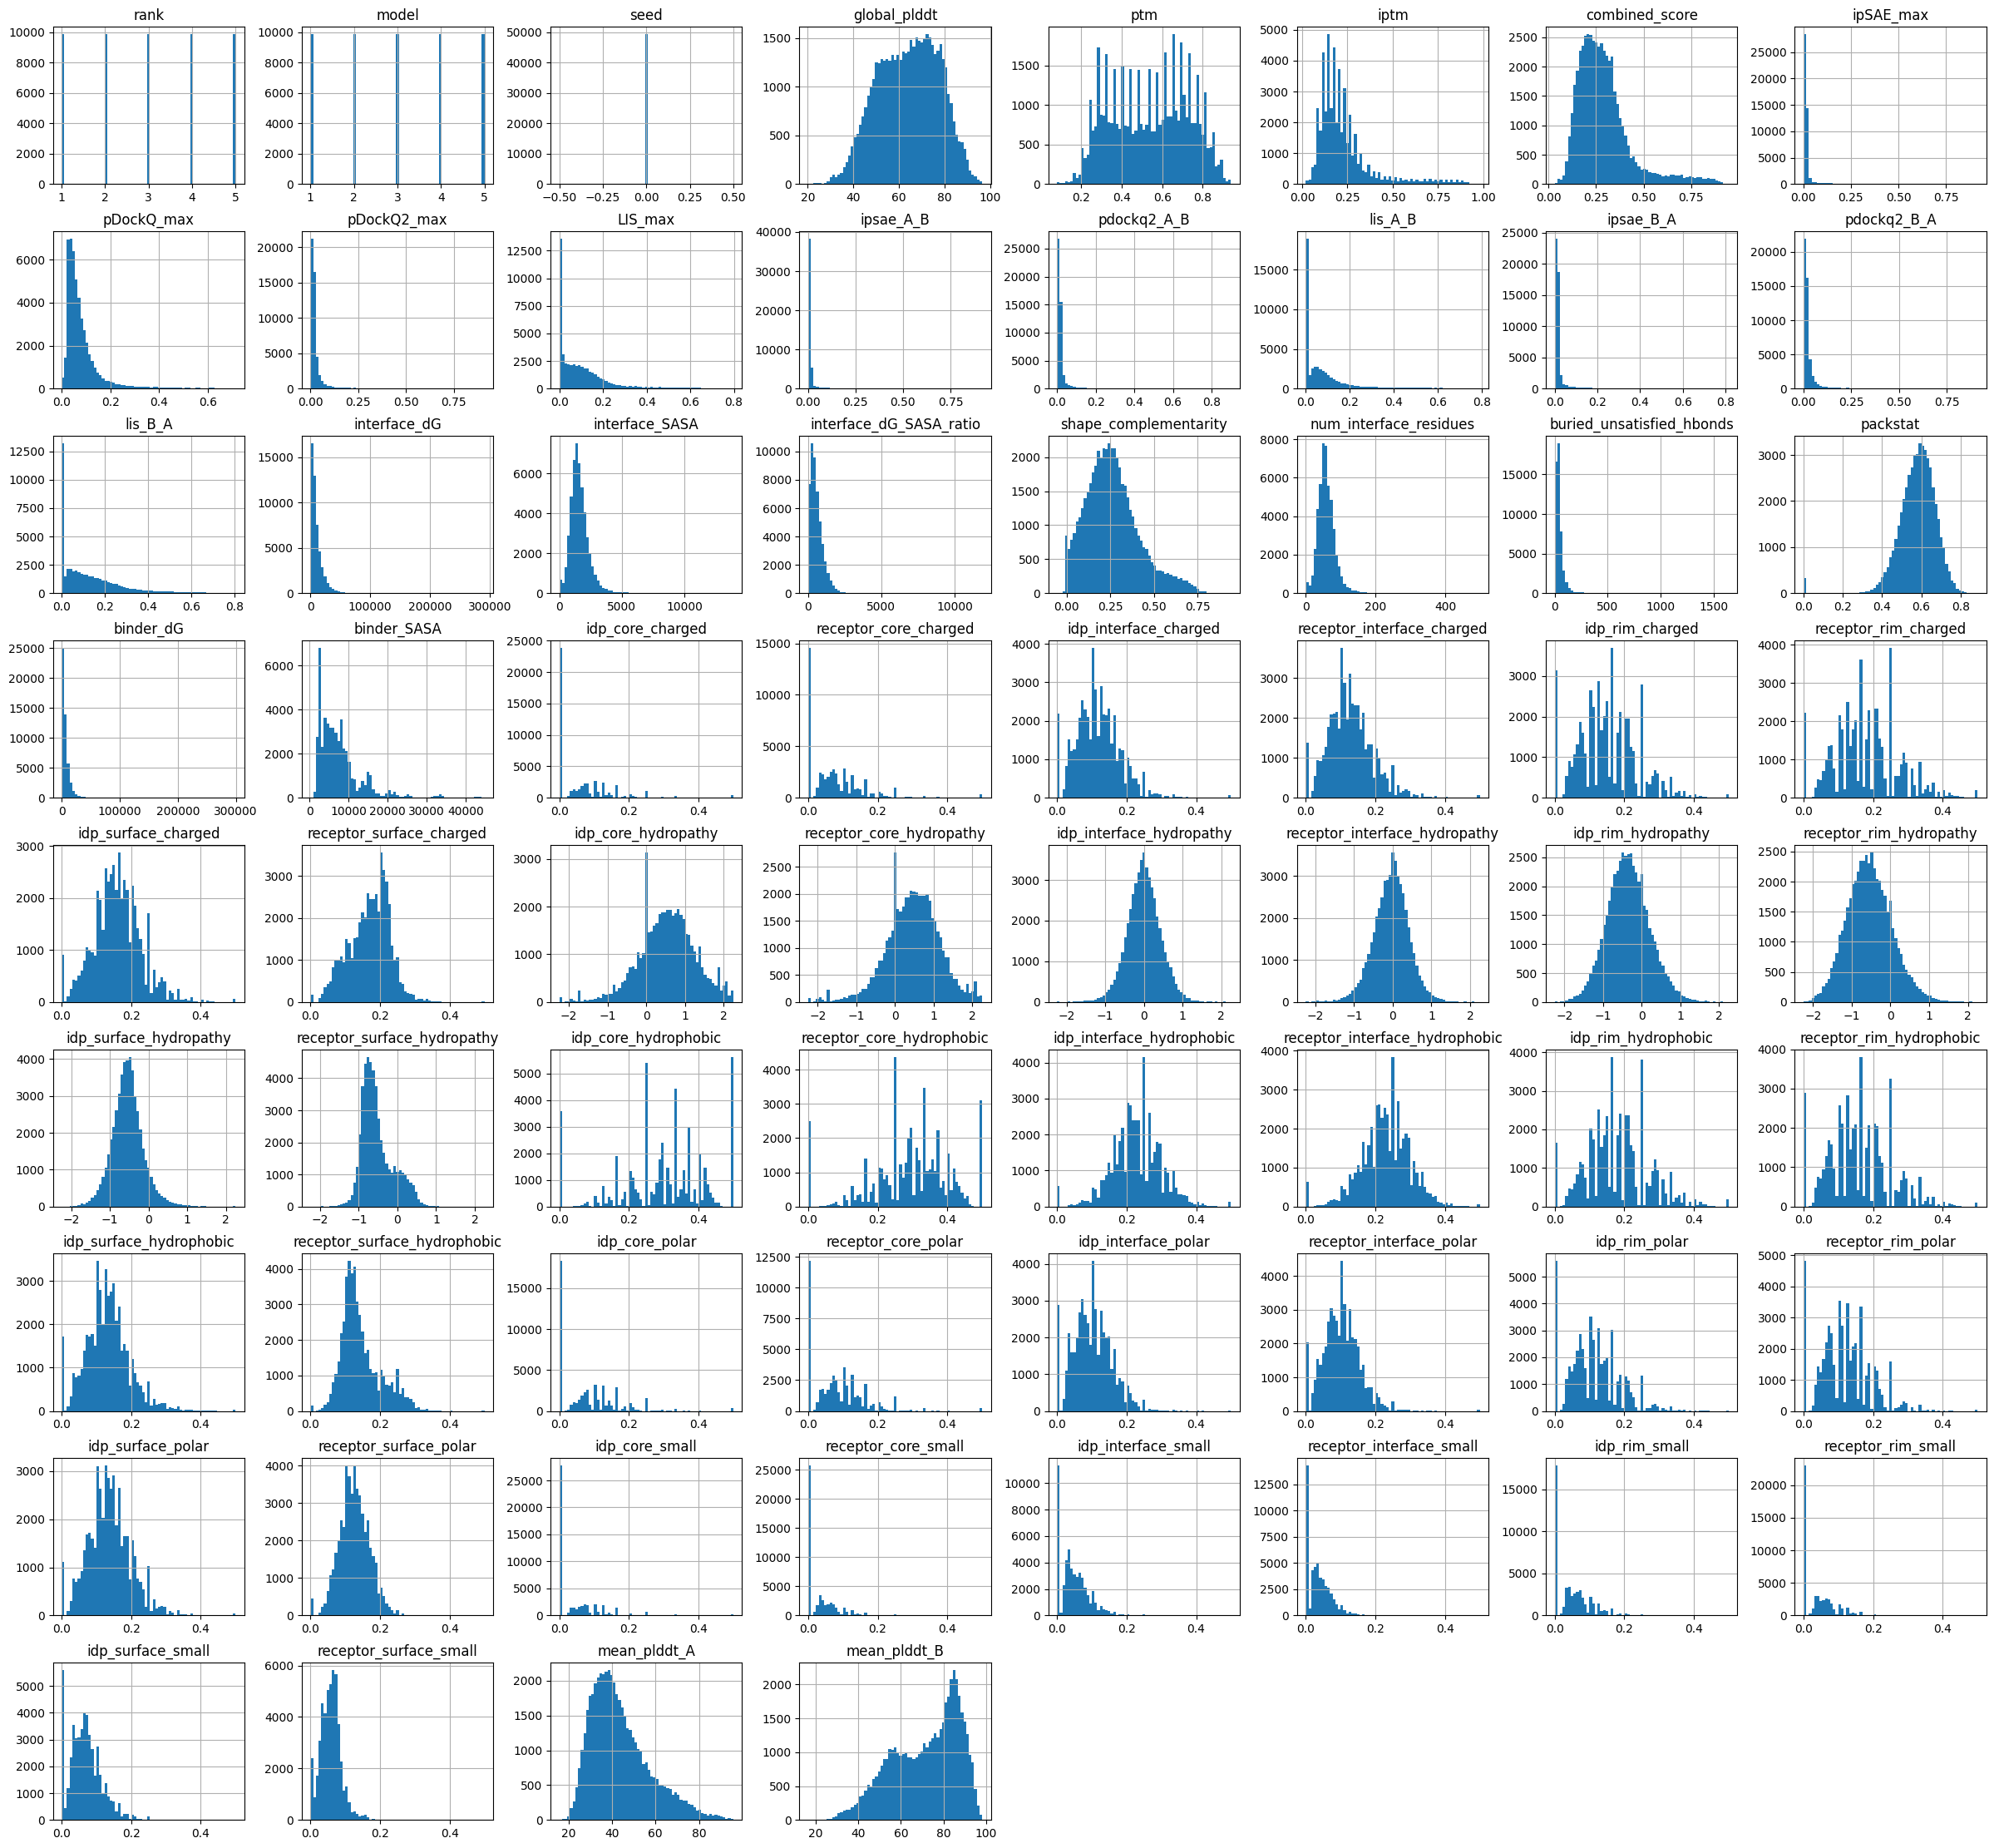

In [39]:
uidr.hist(figsize=(30,28), bins=65)

array([[<Axes: title={'center': 'rank'}>,
        <Axes: title={'center': 'model'}>,
        <Axes: title={'center': 'seed'}>,
        <Axes: title={'center': 'global_plddt'}>,
        <Axes: title={'center': 'ptm'}>,
        <Axes: title={'center': 'iptm'}>,
        <Axes: title={'center': 'combined_score'}>,
        <Axes: title={'center': 'ipSAE_max'}>],
       [<Axes: title={'center': 'pDockQ_max'}>,
        <Axes: title={'center': 'pDockQ2_max'}>,
        <Axes: title={'center': 'LIS_max'}>,
        <Axes: title={'center': 'ipsae_A_B'}>,
        <Axes: title={'center': 'pdockq2_A_B'}>,
        <Axes: title={'center': 'lis_A_B'}>,
        <Axes: title={'center': 'ipsae_B_A'}>,
        <Axes: title={'center': 'pdockq2_B_A'}>],
       [<Axes: title={'center': 'lis_B_A'}>,
        <Axes: title={'center': 'interface_dG'}>,
        <Axes: title={'center': 'interface_SASA'}>,
        <Axes: title={'center': 'interface_dG_SASA_ratio'}>,
        <Axes: title={'center': 'shape_complementari

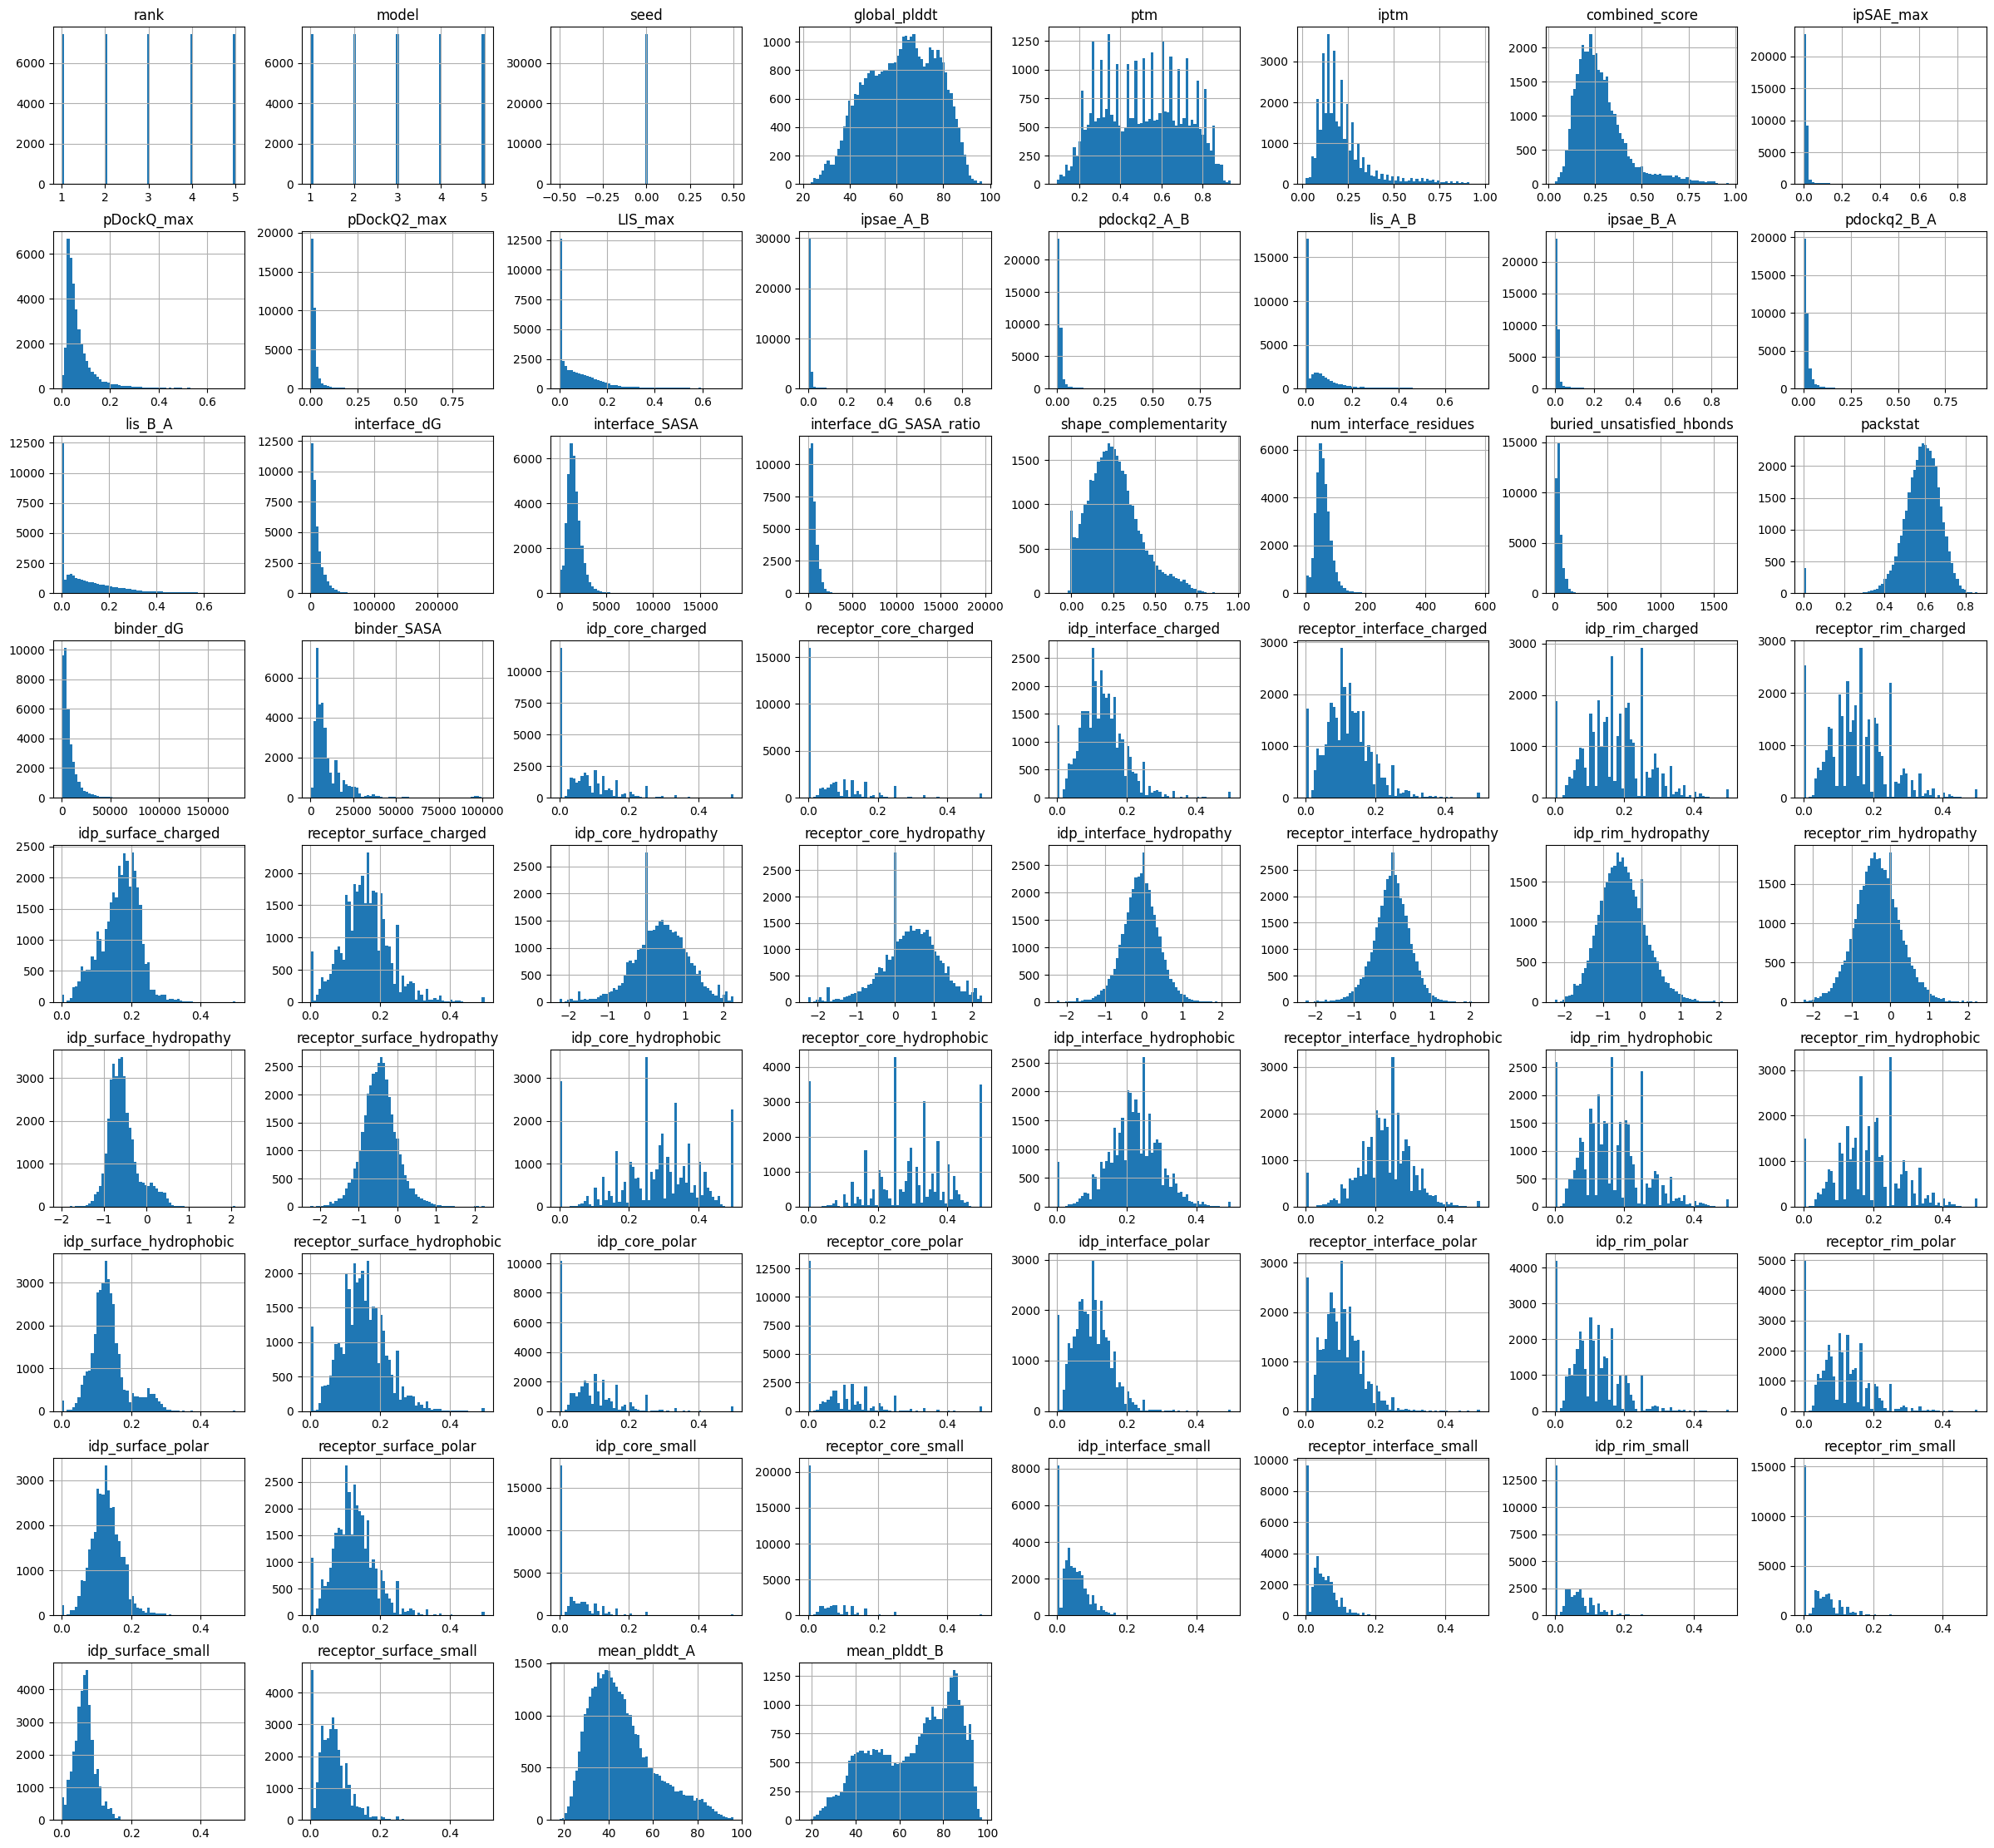

In [40]:
urdi.hist(figsize=(30,28), bins=65)

In [43]:
uidr["interacting_complex"].value_counts()

interacting_complex
False    45510
True      3805
Name: count, dtype: int64

In [44]:
urdi["interacting_complex"].value_counts()

interacting_complex
False    31800
True      5255
Name: count, dtype: int64

In [1]:
uidr

NameError: name 'uidr' is not defined